# Assessment: Weekly deliverable template - Regression
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [232]:
import pandas as pd

df = pd.read_csv('wines_SPA.csv')

# I have done some data analysis previously, and I am aware there are also categorical variables.
# However, I understand from the grading scheme that the focus is more on the models and the evaluation 
# than on data preparation.
# Therefore, I will not perform any encoding of categorical variables at this stage.
# Neither will I impute any missing data, but simply drop rows with missing data.

# Only keep numeric columns. 
# I need to drop the categorical columns first, otherwise dropna() will also remove rows with missing data 
# in categorical columns that have no missing data in numerical columns and hence should remain.
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce')  # Converts 'N.V.' to NaN
median_year = df['year_numeric'].median()
df['year_numeric'].fillna(median_year, inplace=True)
median_year = df['year_numeric'].median()
df['year_numeric'].fillna(median_year, inplace=True)
df['is_nv'] = (df['year'] == 'N.V.').astype(int)


# keep for adding them as features
type_dummies = pd.get_dummies(df['type'], prefix='type', drop_first=True).astype('int64')
type_columns = type_dummies.columns.tolist()
df = pd.concat([df, type_dummies], axis=1)

df = df[df.select_dtypes(include=['float64', 'int64']).columns]

# Drop rows with missing data.
df = df.dropna()

# Remove duplicate rows. I noticed there were a lot of them, and they could skew the results.
df = df.drop_duplicates()

# Display the statistical summary of the dataframe.
print(df.describe())


            rating   num_reviews        price         body      acidity  \
count  1777.000000   1777.000000  1777.000000  1777.000000  1777.000000   
mean      4.412043    544.481711   148.879392     4.258863     2.921216   
std       0.151052   1380.719629   289.323828     0.652836     0.334713   
min       4.200000     25.000000     4.990000     2.000000     1.000000   
25%       4.300000     56.000000    33.030000     4.000000     3.000000   
50%       4.400000    134.000000    58.260000     4.000000     3.000000   
75%       4.500000    499.000000   125.000000     5.000000     3.000000   
max       4.900000  32624.000000  3119.080000     5.000000     3.000000   

       year_numeric        is_nv  type_Cabernet Sauvignon    type_Cava  \
count   1777.000000  1777.000000              1777.000000  1777.000000   
mean    2010.790658     0.034328                 0.005627     0.016320   
std       11.492950     0.182120                 0.074826     0.126737   
min     1910.000000     0.00

/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_12597/4245115269.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['year_numeric'].fillna(median_year, inplace=True)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_12597/4245115269.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

**Observations:**  

The remaining dataset has 1,777 examples.

*rating*

The rating values have a range between 4.2 and 4.9. Having done some analysis previously I can say that removing the duplicates has dramatically improved the distribution of values. The 75% quartile was at 4.2 (the minimum!), and is now at 4.5. Adding/substracting the std to/from the mean shows that 68% of examples have a rating between 4.3 and 4.6, and 95% of examples have rating below 4.8. From these data I expect a reasonably good distribution at a location of 4.4, the median. Rating seems a classic target attribute, as businesses may want to predict customer rating based on a range of criteria, and indirectly (as a proxy label) sales success. I am assuming that "Quality" (from later in the sheet) refers to the "rating" variable. If used as a feature, normalisation is not necessarily required due to the moderate values, but can be done with a standard approach. 

*num_reviews*

From the name I infer that this is the number of available reviews that lead to the "rating". The range is very high between 25 and 32.624. However, the 25% and 75% quartiles are at 56 and 499, respectively. This means that 50% of examples have review numbers in this range. The location is skewed to lower values. The standard deviation is quite high though. Only 68% of examples will have review numbers below mean+std = 1890, and 95% are below mean+2*std = 3243. (I'm ignoring the bottom because the minimum value is higher than mean-std.) This suggest we definitely can see some outliers at the top end (32,624). Simply looking at the magnitudes of numbers I am thinking of a logarithmic curve. Possibly a logarithmic normalisation may be a good approach here as I expect the data to be right-skewed - as is also intuitively expected considering that only few wines will have very high numbers of ratings. 

*price*

We see similar behaviour of the price data: A huge range (4.99–3119.08), a relatively strong 25-75% range (33.015-125) that is located at the lower price range, and again a very high standard deviation that shows that only 68% of examples have a price below 438.19, while 95% have a price below 727.59. The expectation again is to have some outliers at the top end. Again for normalisation, a logarithmic approach may be indicated, maybe even when price is the label. As for correlation analysis it may be an interesting question if the price correlates to rating in some way. Also, the expectation is that the number of reviews is higher towards the lower end of the price range. 

*body*

The range for body is between 2.0 and 5.0, and we don't see any decimals. This could mean this body is likely determined as a rating between 1 and 5. the 25% quartile is at 4. This means that the more than 75% of examples has a body value of 4 or 5, i.e. one of two values. This means the informational content of this attribute is questionable.

*acidity*

For acidity the case is even more extreme: mean-2*std is at 2.25, so 95% of examples have as value 3 (the maximum value). This attribute we can ignore as there is no informational content. 

### 2. At least two exploratory graphs with captions



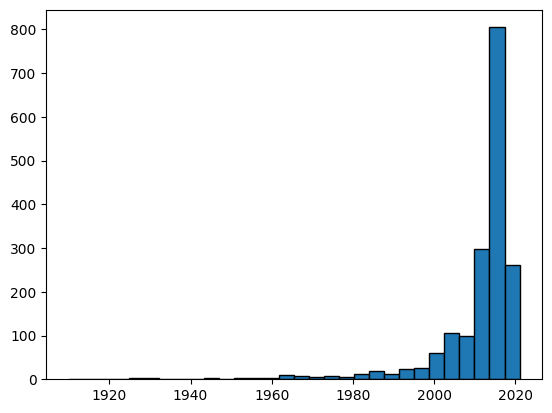

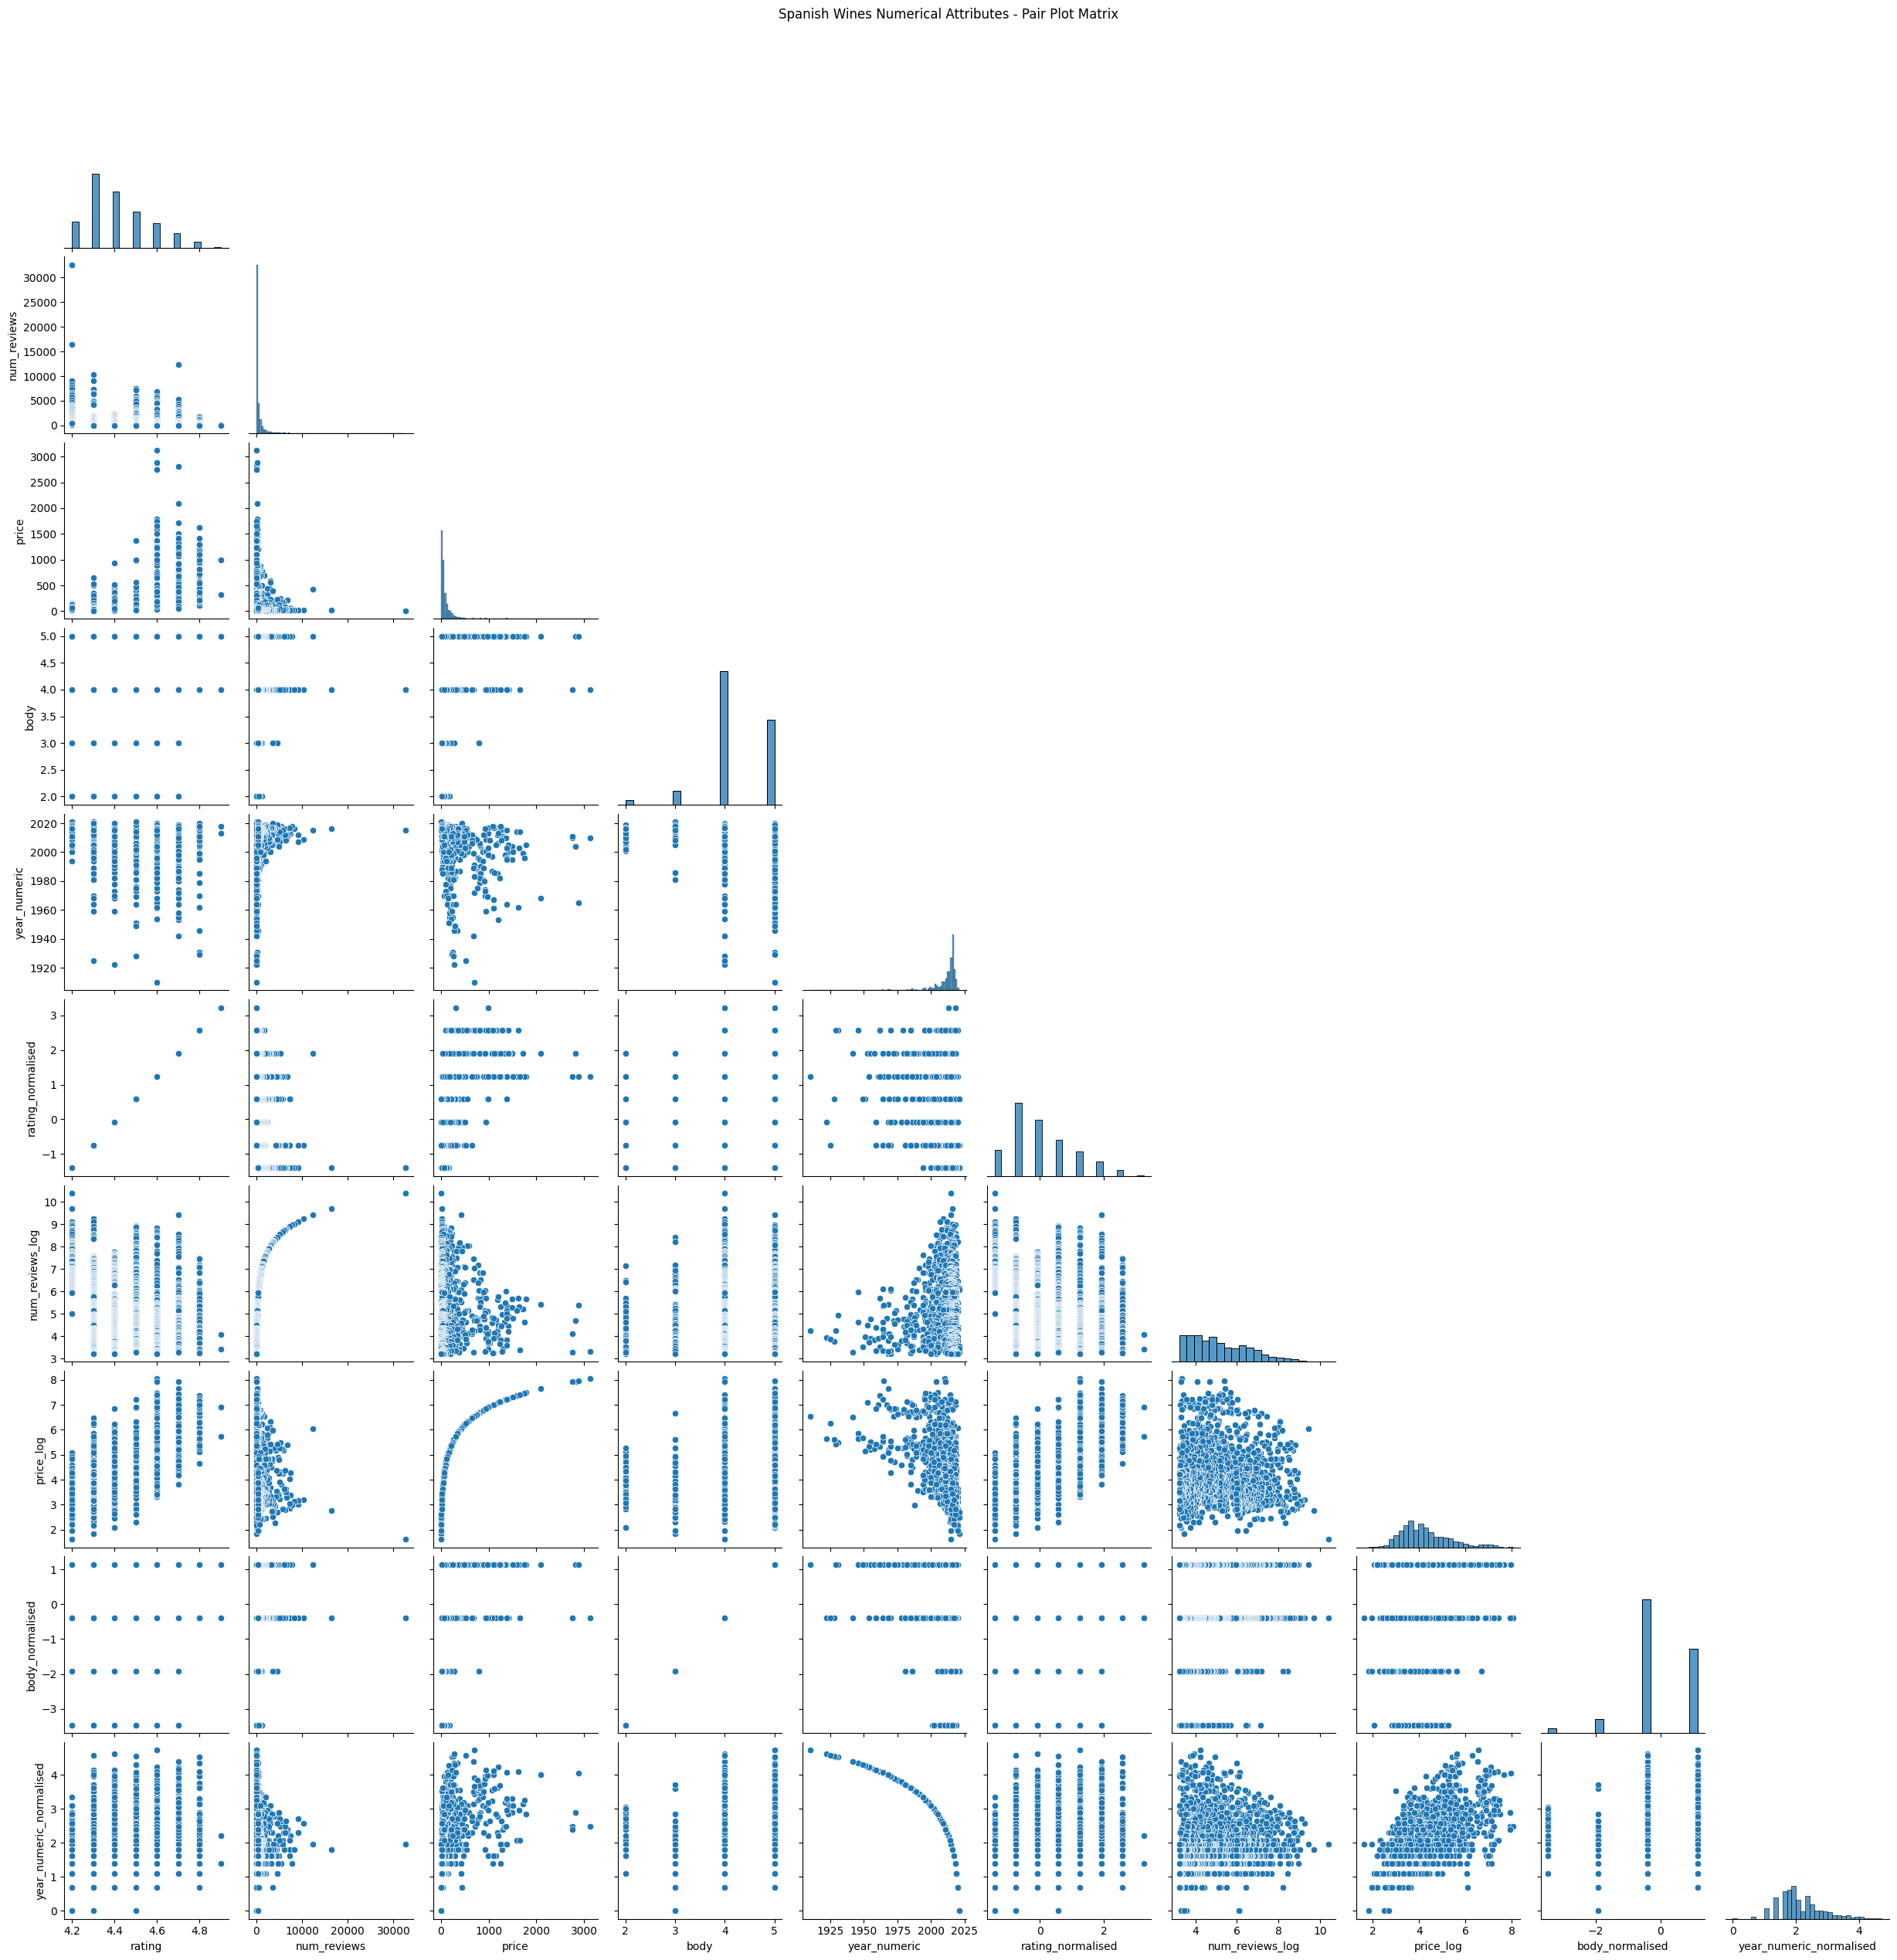

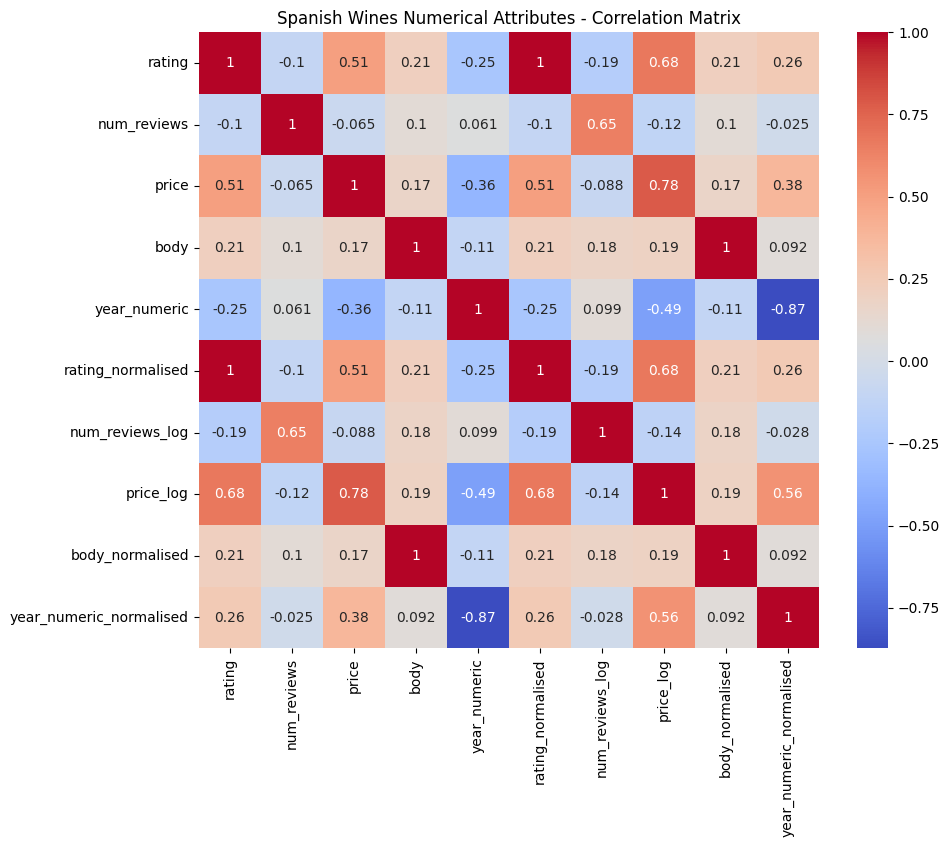

In [233]:
# drop acidity column
df = df.drop(columns=['acidity'])

# Add a normalised version of the rating column.
df['rating_normalised'] = (df['rating'] - df['rating'].mean()) / df['rating'].std()

# Add a logarithmic version of the num_reviews column.
import numpy as np
df['num_reviews_log'] = df['num_reviews'].apply(lambda x: np.log(x))

# Add a logarithmic version of the price column.
df['price_log'] = df['price'].apply(lambda x: np.log(x))

# Add a normalised version of the body column.
df['body_normalised'] = (df['body'] - df['body'].mean()) / df['body'].std()

# Add a normalised version of the year_numeric column.
x = df['year_numeric']
x_reflected = x.max() + 1 - x  # Must be positive
df['year_numeric_normalised'] = np.log(x_reflected)



# Show a pairplot of the dataframe.
import matplotlib.pyplot as plt
import seaborn as sns    

plt.hist(df['year_numeric'], bins=30, edgecolor='black')
plt.show()

df_for_pairplot = df.drop(columns=type_columns+['is_nv'])  


sns.pairplot(df_for_pairplot,
             corner=True
             )
plt.suptitle("Spanish Wines Numerical Attributes - Pair Plot Matrix", y=1.02)
plt.show()

# Show the correlation matrix of the dataframe.
plt.figure(figsize=(10, 8))
sns.heatmap(df_for_pairplot.corr(), 
            annot=True, 
            cmap='coolwarm'
            )
plt.title("Spanish Wines Numerical Attributes - Correlation Matrix")
plt.show()

**Observations:**  

Immediately the **histograms** confirm the assumptions from the statistical data: *num_reviews* and *price* are heavily right-skewed. Rating only shows a light imbalance, which I don't find problematic as it matches the expectation in reality that most wines don't get the highest ratings. *Body* is very dominant on two values, but there is something resembling a normal distribution. However, I am still not sure how much informational content is in the value. I may test it in the module and check the respective coefficient. 

I am surprised how well the **logarithmic normalisation** works for *price* and *num_reviews*. *num_reviews_log* is  much more evenly distributed, and *price_log* has a very good normal distribution, with a small second maximum in a higher price range. I would expect if I were to look into wine types or year, this may clarify this second peak for more expensive wines. 

There are some **outliers** certainly in the *price* and *num_ratings* variables which may skew the result. I will remove the example that has > 20,000 *num_reviews*. As for *price* there seem to be 5 examples that are outliers. I could clip them or drop them. For simplicity I will drop the examples with a *price* > 2,500. 

As for the **pair plots**, *price_log* vs. *rating*/*rating_normalised* catch the eye and should give a good correlation. Other than that, nothing stands out. 

This is confirmed by the **correlation matrix**. It is interesting to see how the correlation rises between *rating* and *price* (0.51) vs. *price_log* (0.68). 

The lack of any other correlations could mean that there are no obvious dependencies between *num_reviews* and *body*, making them suitable to use as features alongside *rating* or *price*, respectively.



### 3. Histogram showing rating imbalance (if any)


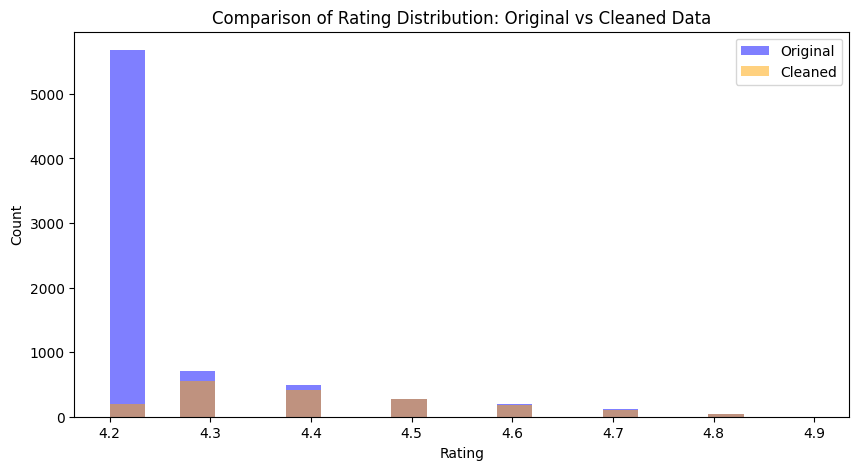

In [234]:
# I know from previous analysis that many duplicates that I removed had the same rating.
# Therefore, I want to see how the rating distribution has changed by dropping the duplicates.

# Reload the original dataframe for comparison
df_original = pd.read_csv('wines_SPA.csv')

# Compare rating between the original and the cleaned dataframe.t

plt.figure(figsize=(10,5))
plt.hist(df_original['rating'], 
         bins=20, alpha=0.5, 
         label='Original', 
         color='blue'
         )
plt.hist(df['rating'], 
         bins=20, 
         alpha=0.5, 
         label='Cleaned', 
         color='orange'
         )
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Comparison of Rating Distribution: Original vs Cleaned Data')
plt.legend()
plt.show()  

**Observations:**  

The graph shows that removing the duplicates from the dataset earlier was an essential step as it changes the *rating* distribution dramatically. 

What was originally a strongly right-skewed distribution now is a more normal distribtution, only slightly skewed to lower values as can be reasonably expected. 

It feels like the overall dataset was joined together from multiple smaller ones, and some of those datasets originally came from the same origin – but obviously that is just speculation. 

However, the cleaned up version does not require additional preparation as the distribution seems intuitively representative.

### 4. Price-regression model + metrics + plot



Price Model Evaluation (Training Set):
Mean Absolute Error (MAE): 0.4557263499091617
Root Mean Squared Error (RMSE): 0.5915178096555371
R^2 Score: 0.6830779197878502

Price Model Test Set Evaluation:
Mean Absolute Error (MAE): 0.4902150809125585
Root Mean Squared Error (RMSE): 0.6517948121747982
R^2 Score: 0.6061009197406763


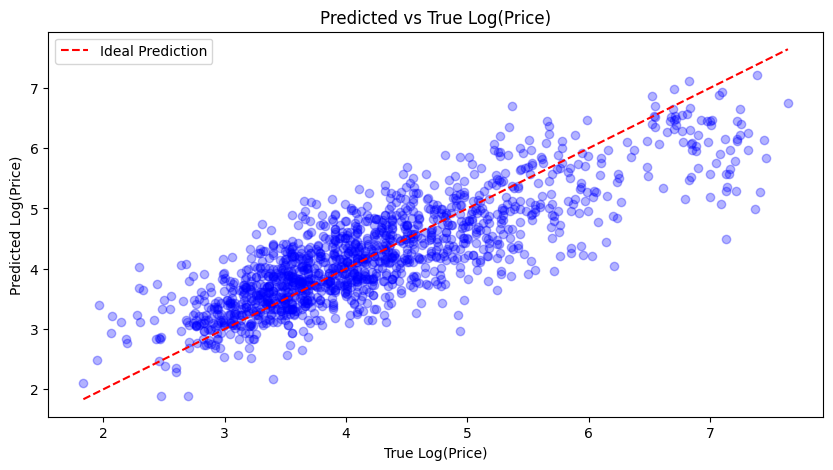

In [241]:
# Firstly, I am removing the outlier examples as previously discussed.
# That is, remove examples with num_reviews > 20000, price > 2500, and year < 1930.   
df = df[(df['num_reviews'] <= 20000) & (df['price'] <= 2500) & (df['year_numeric'] >= 1940)]

# Create test and training sets.

features_price = ['year_numeric_normalised', 'is_nv', 'rating_normalised', 'body_normalised'] + type_columns
target_price = 'price_log'
# I will use 80% of the data for training and 20% for testing.
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
# I will use the log(price) as the target variable because price is strongly right-skewed.
# Also, I am using the log(num_reviews) as a feature for the same reason.
# I will comapre two models: One more complex with three features, and one simple with only one feature.
# I am using body and rating as normalised values to have them on a similar scale as the other features 
# (although I'm not sure if this is necessary as the values are moderate).
X_train_price = train_df[features_price]
y_train_price = train_df[target_price]
X_test_price = test_df[features_price]
y_test_price = test_df[target_price]

# Training the LinearRegression models.
from sklearn.linear_model import LinearRegression  
lr_price = LinearRegression()
lr_price.fit(X_train_price, y_train_price)
# Make predictions on training and test sets.
y_pred_price = lr_price.predict(X_train_price)
y_pred_price_test = lr_price.predict(X_test_price)

# Evaluate the models using MAE, RMSE and R^2 score.
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
mae_price = mean_absolute_error(y_train_price, y_pred_price)
rmse_price = root_mean_squared_error(y_train_price, y_pred_price)
r2_price = r2_score(y_train_price, y_pred_price)
# evaluate the test set as well
mae_price_test = mean_absolute_error(y_test_price, y_pred_price_test)
rmse_price_test = root_mean_squared_error(y_test_price, y_pred_price_test)
r2_price_test = r2_score(y_test_price, y_pred_price_test)
# Print the evaluation metrics.
print("\nPrice Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_price}")
print(f"Root Mean Squared Error (RMSE): {rmse_price}")
print(f"R^2 Score: {r2_price}")
print("\nPrice Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_price_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_price_test}")
print(f"R^2 Score: {r2_price_test}")

# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10,5))
plt.scatter(y_train_price, y_pred_price, alpha=0.3, color='blue')
plt.plot([y_train_price.min(), y_train_price.max()], [y_train_price.min(), y_train_price.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.title('Predicted vs True Log(Price)')
plt.legend()
plt.show()  




**Observations:**  

The **coefficients** in the more complex model meet the expectations:
- *num_reviews_log* correlates negatively with *price_log*. That means, a change of magnitude in number of reviews only influences the magnitude of price by 0.007. That is marginal, considering *num_reviews_log* only has a range between 3 and 10, so a drop of num_reviews_log from max to min (before dropping the outliner!) would result in the increase of 0.05 units of log(price). 
- *body_normalised*, like *num_reviews_log*, has a very small influence given the limited range and the small coefficient. 
- *rating_normalised* is as expected the most influential. An increase of 1 in rating_normalised (a decimal in the actual ratings) changes the log(price) by 0.7, which is almost a doubling of the price (factor 1.9). 


The **evaluation measures** are showing the following:
In both the complex and the simpler model, MAE and RMSE are both rougly 0.6 or 0.76, respectively. This means the predicted log(price) can be expected to be off on average by this number. For the price this would mean a factor 1.6–2.0. So the predicted price could easily be off by more than double/half. That is not very precise.  
Correspondingly, R-squared shows that only 46% of the log(price) variance can be explained with both of these models. This is not very good either. 
Overall, the complex model performs a little bit better than the simple model, but not significantly. For the sake of simplicity, I would go with the simpler model (i.e. only use *rating_normalised* as feature)

The first **visualisation** compares both models and confirms that there is no significant difference. – As for the quality of the models: Notably toward the higher end of the log(price) range, all actuals are higher than the predictions. On the lower end, the predicted prices are higher than the actuals. 

The second visualisation shows normalised rating vs log(price) with the actual regression line based on the simple model (only *rating_normalised* feature). The plot suggests that wines with higher actual price tend to be underpredicted based on ratings, which corresponds to the observation of the frist plot. The observation for lower prices I cannot clearly make out in the second plot. 

### 5. Quality-regression model + metrics + plot



Quality Model Evaluation:
Mean Absolute Error (MAE): 0.08241633696596364
Root Mean Squared Error (RMSE): 0.10212577765871425
R^2 Score: 0.5338643657836152

Quality Model Test Set Evaluation:
Mean Absolute Error (MAE): 0.09008175636750072
Root Mean Squared Error (RMSE): 0.11058295390841584
R^2 Score: 0.47936218871317104


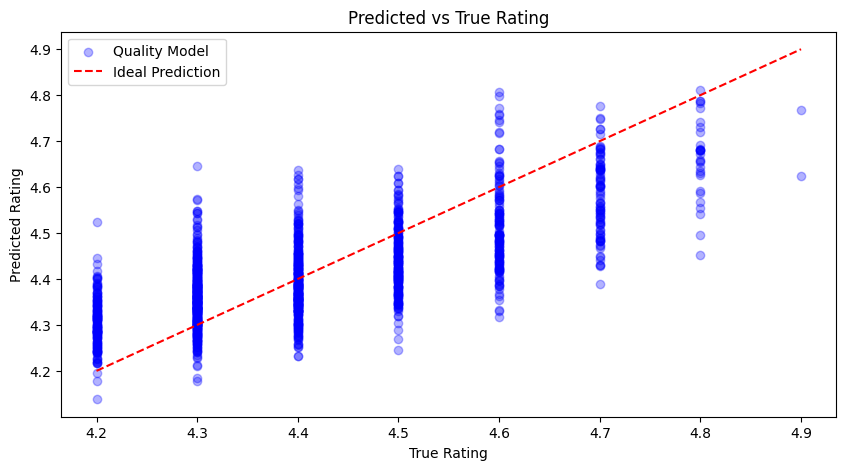

In [242]:
# For the quality model, I am not bothering with a complex model.
features_quality = ['year_numeric_normalised','is_nv','price_log', 'body_normalised'] + type_columns
target_quality = 'rating'
# As target label, I use range which I do not normalise as the values are moderate.
X_train_quality = train_df[features_quality]
y_train_quality = train_df[target_quality]
X_test_quality = test_df[features_quality]
y_test_quality = test_df[target_quality]

# Create and train the LinearRegression model.
lr_quality = LinearRegression()  
lr_quality.fit(X_train_quality, y_train_quality)
# Make predictions on the training set to see how could the model.
y_pred_quality = lr_quality.predict(X_train_quality) 
y_pred_quality_test = lr_quality.predict(X_test_quality)

# Evaluate the model using MAE, RMSE and R^2 score.
mae_quality = mean_absolute_error(y_train_quality, y_pred_quality)
rmse_quality = root_mean_squared_error(y_train_quality, y_pred_quality)
r2_quality = r2_score(y_train_quality, y_pred_quality)
# evaluate the test set as well
mae_quality_test = mean_absolute_error(y_test_quality, y_pred_quality_test)
rmse_quality_test = root_mean_squared_error(y_test_quality, y_pred_quality_test)
r2_quality_test = r2_score(y_test_quality, y_pred_quality_test)
# Print the evaluation metrics.
print("\nQuality Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality}")
print(f"R^2 Score: {r2_quality}")   
print("\nQuality Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality_test}")
print(f"R^2 Score: {r2_quality_test}")

# Visualise the predictions against the true values.
plt.figure(figsize=(10,5))
plt.scatter(y_train_quality, y_pred_quality, alpha=0.3, label='Quality Model', color='blue')
plt.plot([y_train_quality.min(), y_train_quality.max()], [y_train_quality.min(), y_train_quality.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Rating')
plt.legend()
plt.show()  



**Observations:**  

As this model is just the reverse of the Price model, there are no surprises with regards to the metrics. 

However, the visualisations now confirm very strongly what had already been hinted at in the Price model: At the lower end of the prices, ratings are underpredicted, while they are slightly overpredicted at the higher end of the price range. 

The Predicted vs True plot shows that all wines with a 4.2 rating were predicted higher, while almost all wines rated 4.7 or higher were predicted lower. 

Lastly, I tested a number of polynomial regression models just to see how they influence the model quality. The result is that they don't change anything. 

### 6. Over/under-fitting discussion and fix

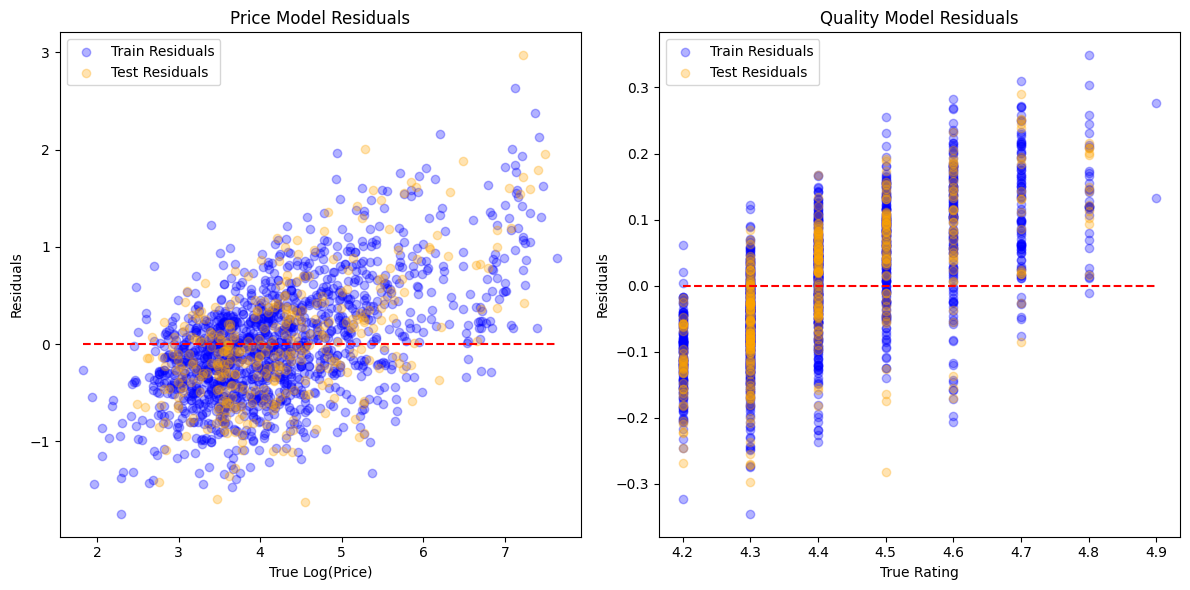

In [238]:
# Residual plots for both models to compare training and test residuals.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_price, y_train_price - y_pred_price, alpha=0.3, color='blue', label='Train Residuals')
plt.scatter(y_test_price, y_test_price - y_pred_price_test, alpha=0.3, color='orange', label='Test Residuals')
plt.hlines(0, y_train_price.min(), y_train_price.max(), colors='red', linestyles='--')
plt.xlabel('True Log(Price)')
plt.ylabel('Residuals')
plt.title('Price Model Residuals')
plt.legend()    
plt.subplot(1, 2, 2)
plt.scatter(y_train_quality, y_train_quality - y_pred_quality, alpha=0.3, color='blue', label='Train Residuals')
plt.scatter(y_test_quality, y_test_quality - y_pred_quality_test, alpha=0.3, color='orange', label='Test Residuals')
plt.hlines(0, y_train_quality.min(), y_train_quality.max(), colors='red', linestyles='--')
plt.xlabel('True Rating')
plt.ylabel('Residuals')
plt.title('Quality Model Residuals')
plt.legend()
plt.tight_layout()
plt.show()




**Observations:**  

For both models, the residual distribution for the Test sets is very similar to the training set. Also, the errors are comparable, as was shown above. There are no extreme outliers. In that sense, there is no overfitting of the models, the generalisation is good. 

On the other hand, the residuals vs the x axis show a clear trend in both models – which is what we already observed when discussing the models individually. So there is still some unsatisfying underfitting.
This could mean that a simple linear regression is maybe not the best approach, or maybe more features like region should be added. 

I have tried polynomials, but that did not give better results. As we don't see overfitting, I also don't think regularisation is the way forward.

With my current knowledge I'm not sure how I could significantly improve the model. 



### 7. Apply cross-validation or statistical analyses on the features or results of the regression models (advanced)

In [254]:
# As I have a lot of features in my model for wine type, I want to see which features are stable, or whether I can remove some.
# In order to do this I will use K-Fold cross-validation to train the model multiple times and observe the variation in coefficients.
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# I scale the features (even when already normalised), so the coefficients are comparable.
X_quality_scaled = StandardScaler().fit_transform(df[features_quality]) 

# I set up K-Fold cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store coefficients from each fold
coefs = []
 
# Target variable in a numpy array
y = df[target_quality].values

# Perform K-Fold cross-validation
for train_idx, test_idx in kf.split(X_quality_scaled):
    X_train, X_test = X_quality_scaled[train_idx], X_quality_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    coefs.append(model.coef_)

# Convert to DataFrame for analysis
coefs_df = pd.DataFrame(coefs, columns=features_quality)

# Analyze mean and std deviation of coefficients across folds
coef_summary = pd.DataFrame({
    'mean_coef': coefs_df.mean(),
    'std_coef': coefs_df.std(),
    'abs_mean': coefs_df.mean().abs()
}).sort_values('abs_mean', ascending=False)

# Calculate the coefficient of variation for each model coefficient (i.e. for each feature)
# by dividing the standard deviation of the coefficients by the absolute means (i.e. the variations across the folds).
# Add a small number (epsilon) just so there is no division by zero
epsilon = 1e-6
cv = coef_summary['std_coef'] / (coef_summary['abs_mean'] + epsilon)
# for each feature, check if the feature coefficient does not always have the same sign across the folds.
sign_flips = coefs_df.apply(np.sign, axis=0).nunique() > 1

# Define thresholds for stability
# cv: if cv >1, the variance is higher than the mean, so the feature is unstable
# abs_mean: if the abs(coefficient) is very small, the feature is not important
cv_threshold = 1.0
abs_mean_threshold = 0.01

# Calculate stability mask:
# cv under the threshold, abs_mean above the threshold, and no sign flips
stable_mask = (cv < cv_threshold) & (coef_summary['abs_mean'] > abs_mean_threshold) & (~sign_flips)

# Add Stable column
coef_summary['Stable'] = stable_mask

print("RESULTS FOR QUALITY MODEL\n")
print(coef_summary)

# Now I do the same for the price model.
X_price_scaled = StandardScaler().fit_transform(df[features_price]) 
kf = KFold(n_splits=5, shuffle=True, random_state=1)
coefs = []
y = df[target_price].values
for train_idx, test_idx in kf.split(X_price_scaled):
    X_train, X_test = X_price_scaled[train_idx], X_price_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = LinearRegression()
    model.fit(X_train, y_train)
    coefs.append(model.coef_)
coefs_df = pd.DataFrame(coefs, columns=features_price)
coef_summary_price = pd.DataFrame({
    'mean_coef': coefs_df.mean(),
    'std_coef': coefs_df.std(),
    'abs_mean': coefs_df.mean().abs()
}).sort_values('abs_mean', ascending=False)
cv = coef_summary_price['std_coef'] / (coef_summary_price['abs_mean'] + epsilon)
sign_flips = coefs_df.apply(np.sign, axis=0).nunique() > 1
stable_mask = (cv < cv_threshold) & (coef_summary_price['abs_mean'] > abs_mean_threshold) & (~sign_flips)
coef_summary_price['Stable'] = stable_mask
print("\nRESULTS FOR PRICE MODEL\n")
print(coef_summary_price)


RESULTS FOR QUALITY MODEL

                           mean_coef  std_coef  abs_mean  Stable
price_log                   0.120650  0.002179  0.120650    True
year_numeric_normalised    -0.033919  0.001528  0.033919    True
is_nv                      -0.020034  0.002759  0.020034    True
type_Sherry                 0.016093  0.003470  0.016093    True
type_Pedro Ximenez          0.014202  0.002236  0.014202    True
type_Cava                   0.013926  0.001606  0.013926    True
type_Priorat Red           -0.012668  0.001211  0.012668    True
body_normalised             0.012121  0.001349  0.012121    True
type_Verdejo                0.007117  0.001247  0.007117   False
type_Red                    0.006623  0.000577  0.006623   False
type_Ribera Del Duero Red   0.006224  0.000917  0.006224   False
type_Sauvignon Blanc        0.006023  0.001285  0.006023   False
type_Montsant Red          -0.005545  0.001631  0.005545   False
type_Sparkling              0.005184  0.001155  0.005184   Fals

**Observations:**  

This analysis was an eye opener for me in the sense that it is possible and possibly useful to use categorical features - but not all of their values - in order to keep the model as simple as possible!

The result for the Quality model shows that price_log is by far the most influencial feature. 

Looking at year_numeric_normalised and is_nv, I am surprised that they are so closely together. is_nv indicates that the year was originally missing, and I imputed the values with median data. I am now wondering if that was a good idea. Maybe 'N.V.' was set on purpose for a special type of wine. A bit far fetched, but maybe this contributes to the distortion in the residuals analysis. At least in the next step I would have a closer look at the data with this in mind. 

What also stands out is that the type of wine only partially influences the quality rating, i.e. only a few wine types have a measurable influence on quality. 

The situation is a little different for the price model. Rating and Year have a comparable influence on the price prediction. The influence of is_nv is relatively smaller. Which means the influence on price of the wines with missing year is smaller than on the ratings. 

On the other hand, more wine types influence the price compared to rating.

Body is a "stable" feature for quality ratings, but does not influence the price, which intuitively is in line with expectation (the assumption being that people prefer full bodied wines.)



